# Below is with Generic Likelihood Model Class

In [2]:
import os, csv, random
from __future__ import division
from matplotlib import  pyplot as plt
import numpy as np
import scipy.io as sio
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [3]:
class Pairwise(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        super(Pairwise, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        '''
        Here params is a list: [pairs, w]
        '''
        out = 1
        pairs = self.endog
        w = params
        
        for pair in pairs:
            out *= 1/(1+np.exp(-w[pair[0]] + w[pair[1]]))   
            
        return -np.log(out)
    
    def fit(self, start_params=None, maxiter=1000, maxfun=5000):  
        return super(Pairwise, self).fit(start_params=start_params, maxiter=maxiter, maxfun=maxfun)

# Generate Data randomly

In [28]:
def compare_rank(video_score, results, verbose=False, hist=False, pct=100):
    true_order = np.array(video_score).argsort()
    true_ranks = true_order.argsort()

    temp_o = np.array(results.params).argsort()
    temp_r = temp_o.argsort()

    resolution = 0.1
    video_score_results = np.round(results.params/resolution)*resolution
    
    if verbose:
        print 'Result Order \t True Order \t Result Score \t Ture Score'
        for i in range(len(temp_r)):
            print temp_r[i], '\t\t', true_ranks[i], '\t\t', video_score_results[i], '\t\t', video_score[i]
            
    if hist:
        
        diff = np.abs(temp_r - true_ranks)
        plt.hist(diff, alpha=0.5)
#         plt.title('Histogram of ranking difference between truth and predictions with %d percent of pairs' % pct)

In [12]:
video_num = 30

video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)

In [13]:
model = Pairwise(pairs_truth)
# w_init = np.ones(video_num)
w_init = np.random.uniform(-5,5,video_num)
results = model.fit(w_init, maxiter=100000, maxfun=50000)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 31798
         Function evaluations: 38751


In [14]:
compare_rank(video_score, results, True)

Result Order 	 True Order 	 Result Score 	 Ture Score
13 		13 		42092.2 		-1.0
27 		27 		142976.2 		4.2
12 		12 		36013.8 		-1.1
9 		9 		35595.1 		-1.9
1 		1 		-68036.9 		-4.0
19 		19 		54262.8 		1.4
25 		25 		142065.1 		3.7
5 		5 		-40592.0 		-3.0
26 		26 		142343.6 		4.1
17 		17 		50607.0 		0.5
2 		2 		-67989.0 		-3.9
11 		11 		35674.5 		-1.3
3 		3 		-67894.9 		-3.5
18 		18 		51034.8 		1.1
14 		14 		50427.9 		-1.0
6 		6 		-40471.8 		-3.0
8 		8 		35544.7 		-2.2
24 		24 		115351.1 		3.1
21 		21 		114345.1 		2.0
28 		28 		143242.4 		4.5
15 		15 		50465.6 		-0.5
29 		29 		290974.5 		4.7
10 		10 		35636.2 		-1.7
0 		0 		-155414.4 		-4.2
7 		7 		35498.8 		-2.8
20 		20 		54558.9 		1.5
22 		22 		114409.8 		2.1
23 		23 		114470.3 		2.8
4 		4 		-42374.2 		-3.4
16 		16 		50550.8 		0.1


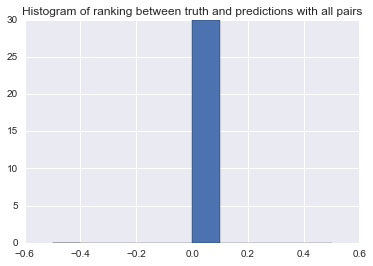

In [16]:
diff = np.abs(temp_r - true_ranks)
plt.hist(diff)
plt.title('Histogram of ranking between truth and predictions with all pairs')

Current evaluating with 190 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 12429
         Function evaluations: 16097
Current evaluating with 152 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2858
         Function evaluations: 4041
Current evaluating with 114 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 13514
         Function evaluations: 17419
Current evaluating with 76 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1302
         Function evaluations: 2059
Current evaluating with 38 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2722
         Function evaluations: 3860


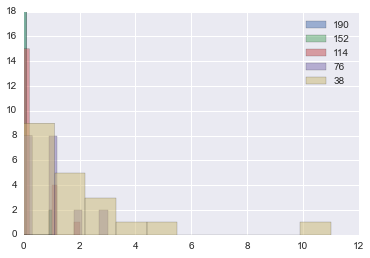

In [32]:
video_num = 20
video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)  


# num_test_pairs = (np.array((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1))*total_pairs).astype(int)
num_test_pairs = (np.array((1,0.8,0.6,0.4,0.2))*total_pairs).astype(int)
# num_test_pairs = (np.array((0.1, 0.2, 0.3))*total_pairs).astype(int)
num_to_be_flipped = np.array((0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5))


for test_pair_num in num_test_pairs:
    print 'Current evaluating with %d test pairs' % test_pair_num
    test_pairs = [pairs_truth[i] for i in random.sample(range(total_pairs), test_pair_num)]
    model = Pairwise(test_pairs)
    w_init = np.random.uniform(-5,5,video_num)
    results = model.fit(w_init, maxiter=100000, maxfun=50000)
    compare_rank(video_score, results, False, True, int(test_pair_num/total_pairs*100))
plt.legend([str(i) for i in num_test_pairs])

Current evaluating with 0.050000 to flip
Optimization terminated successfully.
         Current function value: 0.336758
         Iterations: 8938
         Function evaluations: 11296
Current evaluating with 0.150000 to flip
Optimization terminated successfully.
         Current function value: 0.462347
         Iterations: 18649
         Function evaluations: 23413
Current evaluating with 0.250000 to flip
Optimization terminated successfully.
         Current function value: 0.669138
         Iterations: 15997
         Function evaluations: 20064
Current evaluating with 0.400000 to flip
Optimization terminated successfully.
         Current function value: 0.639298
         Iterations: 16954
         Function evaluations: 21270
Current evaluating with 0.600000 to flip
Optimization terminated successfully.
         Current function value: 0.626728
         Iterations: 18208
         Function evaluations: 22781


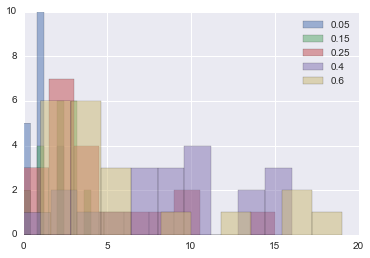

In [40]:
video_num = 20
video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)  



num_test_pairs = total_pairs
num_to_be_flipped = np.array((0.05, 0.15, 0.25,  0.4, 0.6))


for to_flip in num_to_be_flipped:
    print 'Current evaluating with %f to flip' % to_flip
    
    test_pairs_with_error = pairs_truth
    
    num_to_flip = int(num_test_pairs*to_flip)
    
    for i in random.sample(range(num_test_pairs), num_to_flip):
        test_pairs_with_error[i] = (pairs_truth[i][1],pairs_truth[i][0])
        
    model = Pairwise(test_pairs_with_error)
    w_init = np.random.uniform(-5,5,video_num)
    results = model.fit(w_init, maxiter=100000, maxfun=50000)
    compare_rank(video_score, results, False, True, int(test_pair_num/total_pairs*100))
plt.legend([str(i) for i in num_to_be_flipped])

# Read data from file

In [3]:
def append_pair(comp, name1, name2, name_to_num):
    if comp == '-1':
        return((name_to_num[name2], name_to_num[name1]))
    if comp == '1':
        return((name_to_num[name1], name_to_num[name2]))

In [4]:
# Used to store video name and their corresponding index
name_to_num = dict()
# Here pairs will be a list of 5 lists correpesonding to each of the 5 traits
pairs = [[],[],[],[],[]]

j = 0
path = './data'
files = [f for f in os.listdir(path) if f.endswith('.csv')]
for file in files:
    with open('./data/'+file, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        for row in reader:
            if not row[1] in name_to_num:
                name_to_num[row[1]] = j
                j += 1
            if not row[2] in name_to_num:
                name_to_num[row[2]] = j
                j += 1
            for i in range(3,8):
                pair = append_pair(row[i],row[1],row[2],name_to_num)
                if pair != None:
                    pairs[i-3].append(pair)
video_num = j

In [5]:
name_to_num

{'../videos/-DXzJ6jxhOM.001.mp4': 28,
 '../videos/-_e7j8_W77g.000.mp4': 25,
 '../videos/-yuIc0nWsvs.000.mp4': 0,
 '../videos/1fvBSv1cNUU.000.mp4': 26,
 '../videos/1oEY1QQ_6ss.001.mp4': 8,
 '../videos/2IC74dLuG_U.000.mp4': 3,
 '../videos/2lCNSi1JD7w.001.mp4': 22,
 '../videos/2ltp6TYwjJE.001.mp4': 6,
 '../videos/3L1qnlifDk8.001.mp4': 19,
 '../videos/3NHxfy58SqA.000.mp4': 14,
 '../videos/3jdbKrQKw2s.002.mp4': 20,
 '../videos/4GTKcoCJHBs.002.mp4': 4,
 '../videos/4ZBHzdkFDrY.001.mp4': 18,
 '../videos/4ssTy-NvTLg.000.mp4': 17,
 '../videos/5izh7-zFFdg.001.mp4': 9,
 '../videos/6Z5NhCtqEkw.002.mp4': 27,
 '../videos/6yWbfD71gH4.002.mp4': 5,
 '../videos/84ieZEdwBN8.001.mp4': 16,
 '../videos/8CZEYuJQPX8.002.mp4': 13,
 '../videos/9iKnGQiOSt0.002.mp4': 10,
 '../videos/9oVaec0OVIg.002.mp4': 11,
 '../videos/AdLIA3nYSkU.001.mp4': 15,
 '../videos/B6QtDf9sIvQ.001.mp4': 21,
 '../videos/BBWnOheRxss.000.mp4': 24,
 '../videos/BOAekq80wBc.001.mp4': 29,
 '../videos/CG8vq7r1RqM.000.mp4': 23,
 '../videos/D69eTQ3

In [60]:
# estimated_for_each_trait = []
# for i in range(5):
#     print 'Evaluating trait %d', i+1
#     model = Pairwise(pairs[i])
#     w_init = np.random.uniform(-1000,1000,30)
#     results = model.fit(w_init, maxiter=1000000, maxfun=1000000)
#     estimated_for_each_trait.append(results.params)

In [49]:
model = Pairwise(pairs[0])
w_init = np.zeros(30)
results = model.fit(w_init, maxiter=1000000, maxfun=1000000)

Optimization terminated successfully.
         Current function value: 0.585953
         Iterations: 17793
         Function evaluations: 20971


In [ ]:
# Multi processor parallel code. Not very successful

from multiprocessing import Pool

estimated_for_each_trait = {}

def f(i):
    print 'Evaluating trait %d', i+1
    model = Pairwise(pairs[i])
    w_init = np.random.uniform(-5,5,video_num)
    results = model.fit(w_init, maxiter=1000000, maxfun=1000000)
    estimated_for_each_trait[str(i)] = results.params
    return estimated_for_each_trait

def mp_handler():
    p = multiprocessing.Pool(8)
    p.map(f, [0,1,2,3,4])
    
mp_handler()